# Stabilize inverted pendulum with LQR control

In [53]:
import numpy as np

import torch
from torchdyn.numerics.odeint import odeint
from torchcontrol.systems.classic_control import Pendulum, LTISystem
from torchcontrol.cost import IntegralCost
from torchcontrol.controllers import *

from common import plot_phase_space, plot_traj

import control

device = torch.device('cpu')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [114]:
# Declaring the cost function
x_star = torch.Tensor([[torch.pi, 0]]).to(device)
u_star = 0.
cost = IntegralCost(x_star=x_star, u_star=u_star, P=0, Q=1, R=0)

ctrl = NoController().to(device)
pendulum = Pendulum(ctrl, solver='dopri5')


In [115]:
pendulum.dynamics(0, x_star)

tensor([[0.0000e+00, 8.5762e-07]])

# Simulate unforced system

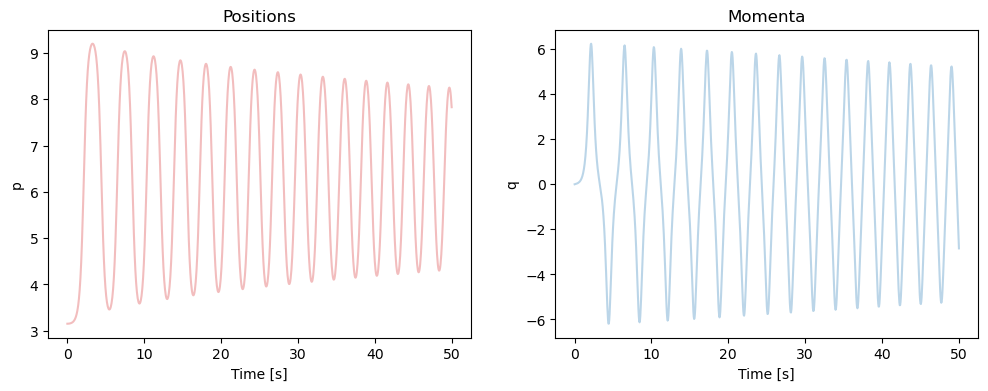

In [116]:
# Unstable equilibrium
x0_p = torch.Tensor([[1e-2, 0.0]]).to(device)
x0 = x_star + x0_p

# Time span
dt = 0.05 # step size
t0, tf = 0, 50 # initial and final time
steps = int((tf - t0)/dt) + 1
t_span = torch.linspace(t0, tf, steps).to(device)

traj = pendulum(x0, t_span)

plot_traj(traj, t_span)

In [117]:
A, B = pendulum.linearize(x_star)
A, B = A.detach().numpy(), B.detach().numpy()
C = np.eye(pendulum.state_dim)
D = np.zeros((pendulum.state_dim, 1))

print(np.linalg.eigvals(A))

sys = control.ss(A, B, C, D)
sys

tensor([[0.]])
[ 3.127096 -3.137096]


<LinearIOSystem:sys[12]:['u[0]']->['y[0]', 'y[1]']>

In [134]:
# LQR design
Q = 1e0 * np.eye(pendulum.state_dim)
R = 1e2 * np.eye(pendulum.act_dim)

K, _, evals = control.lqr(sys, Q, R)

print(K)
print(evals)

[[19.62051051  6.25507151]]
[-3.180182 +0.j -3.0848894+0.j]


# Test linearized system

In [135]:
A - B @ K

array([[ 0.        ,  1.        ],
       [-9.81051009, -6.26507151]])

/Users/jared/Dropbox/Documents/2023/collimator/torchcontrol/torchcontrol/systems/classic_control.py:37: UserWarning: Controller weigth matrix B not specified; using default identity matrix
  warn("Controller weigth matrix B not specified;"


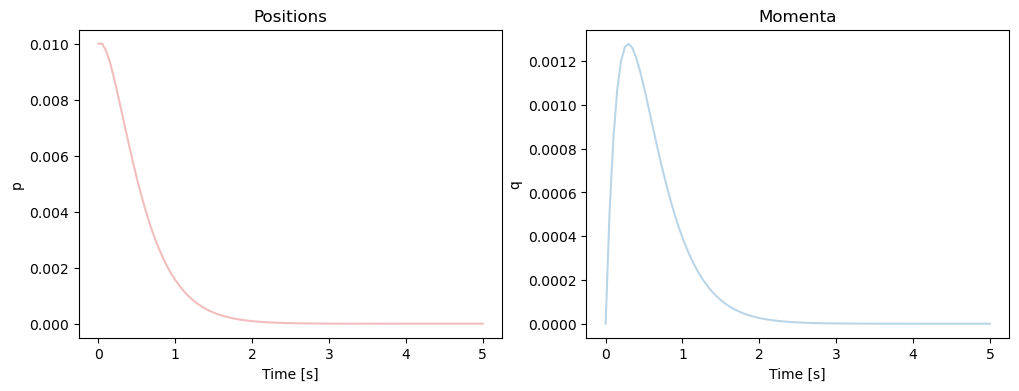

In [136]:
A_cl = torch.tensor(A - B @ K, dtype=torch.float, device=device)
pendulum_cl_lin = LTISystem(A=A_cl, B=None, u=NoController().to(device))


traj = pendulum_cl_lin(x0_p, t_span)
plot_traj(traj, t_span)

# Simulate nonlinear system

In [137]:
from torchcontrol.controllers import LinearFeedbackController

K = torch.tensor(K, device=device, dtype=torch.float)
ctrl = LinearFeedbackController(K, x0=x_star).to(device)
pendulum_cl = Pendulum(ctrl, solver='dopri5')

In [138]:
x_star

tensor([[3.1416, 0.0000]])

tensor([[3.1516, 0.0000]])


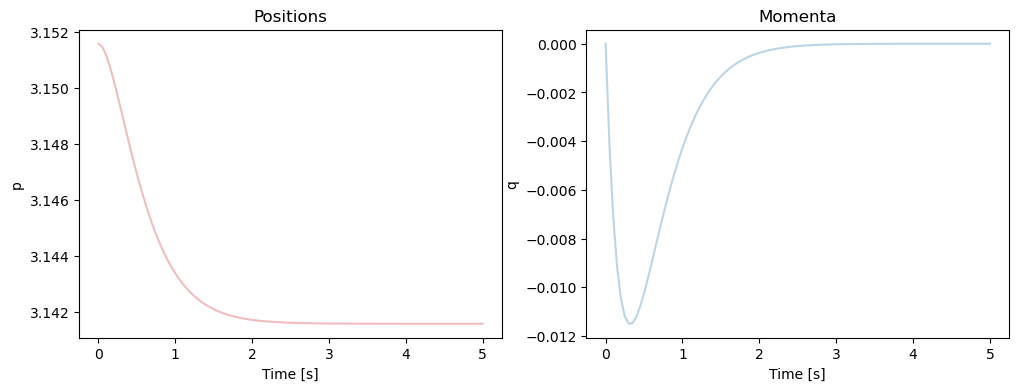

In [139]:
x0 = x_star + x0_p
print(x0)
# Time span
dt = 0.05 # step size
t0, tf = 0, 5 # initial and final time
steps = int((tf - t0)/dt) + 1
t_span = torch.linspace(t0, tf, steps).to(device)

traj = pendulum_cl(x0, t_span)

plot_traj(traj, t_span)

# Batch trajectories

In [140]:
x_lim = torch.pi # limit of the state distribution (in rads and rads/second)
init_dist = torch.distributions.Uniform(torch.Tensor([-x_lim, -x_lim]), torch.Tensor([x_lim, x_lim]))

x0 = init_dist.sample((100,)).to(device)
traj = pendulum(x0, t_span)

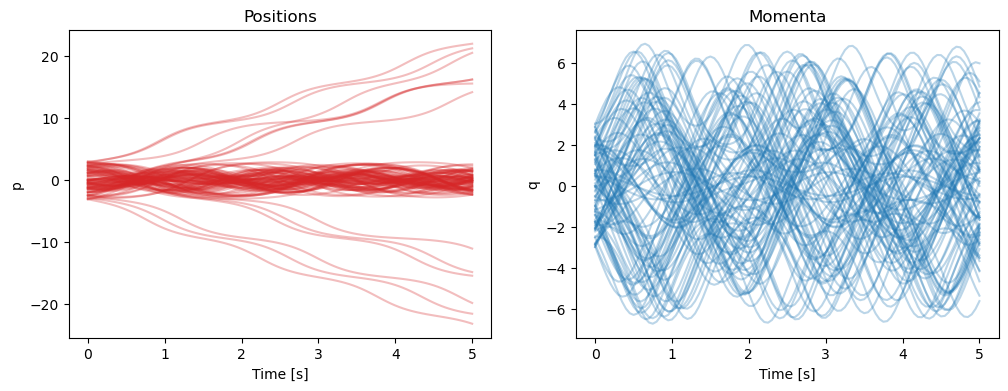

In [141]:
plot_traj(traj, t_span)

/Users/jared/opt/anaconda3/envs/collimator/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525699189/work/aten/src/ATen/native/TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


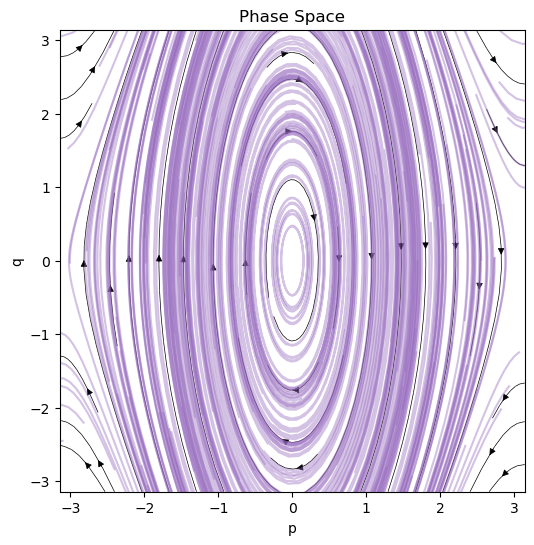

In [143]:
plot_phase_space(pendulum, traj)

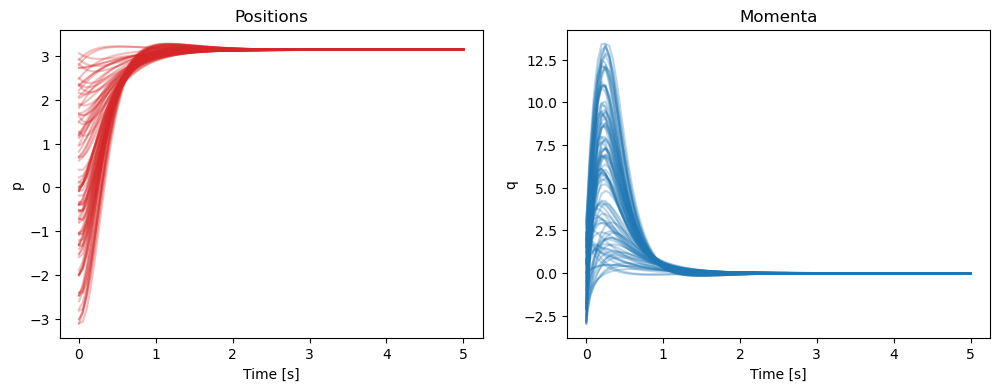

In [144]:
traj_cl = pendulum_cl(x0, t_span)
plot_traj(traj_cl, t_span)

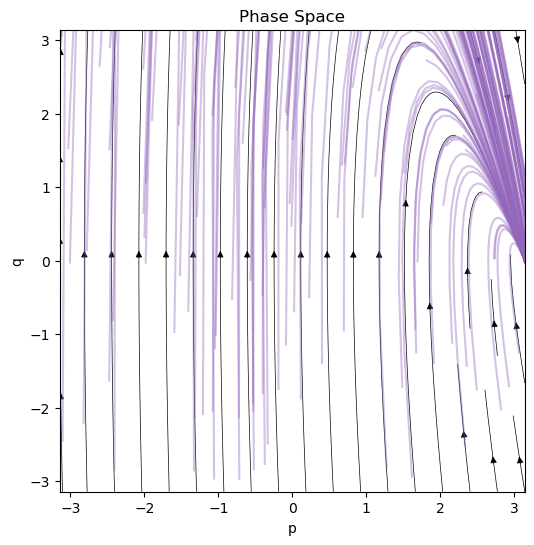

In [145]:
plot_phase_space(pendulum_cl, traj_cl)